<a href="https://colab.research.google.com/github/sangeetajay/CNN_projects/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_r9fjh2t
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_r9fjh2t


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


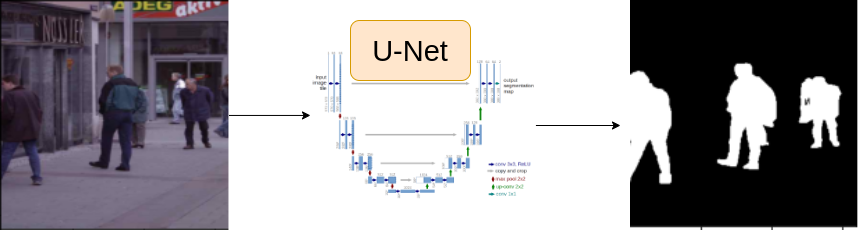

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'efficientnet-b0'
WEIGHTS = 'imagenet'


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
# we want to see image from row 4
row = df.iloc[4]
image_path = row.images  
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0



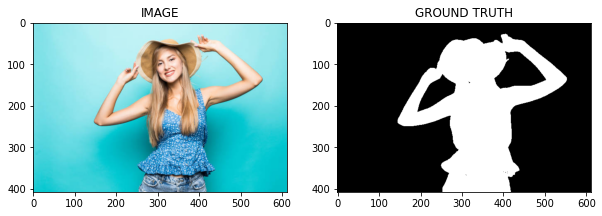

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
from albumentations.augmentations.transforms import VerticalFlip
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE, IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([ 
                    A.Resize(IMG_SIZE, IMG_SIZE)
  ])
      

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
 class SegmentationDataset(Dataset):

   def __init__(self, df, augmentations):

     self.df = df
     self.augmentations = augmentations

   def __len__(self):
     return len(self.df)

   def __getitem__(self, idx):

     row = self.df.iloc[idx]

     image_path = row.images
     mask_path = row.masks 

     image = cv2.imread(image_path)
     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w, c)
     mask = np.expand_dims(mask, axis = -1)

     if self.augmentations:
       data = self.augmentations(image = image, mask = mask)
       image = data['image']
       mask = data['mask']

     #(h,w,c) -> (c, h, w)

     image = np.transpose(image, (2,0,1)).astype(np.float32)
     mask = np.transpose(mask, (2,0,1)).astype(np.float32)

     #convert from numpy to tensor
     image = torch.Tensor(image) / 255.0
     mask = torch.round(torch.Tensor(mask) / 255.0)

     return image, mask 

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


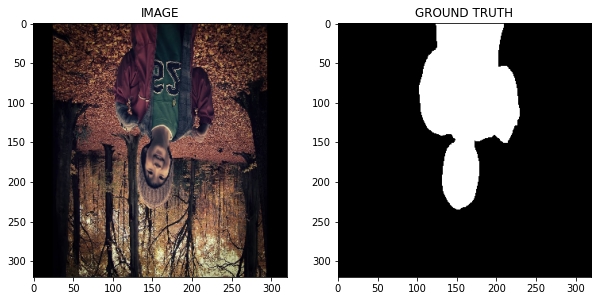

In [ ]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss


In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels= 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2 

    return logits   

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images,masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED_MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


SAVED_MODEL
Epoch : 1 Train_loss : 0.46333605448404946 Valid_loss : 3.019727885723114


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


SAVED_MODEL
Epoch : 2 Train_loss : 0.3378735880057017 Valid_loss : 1.856014996767044


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


SAVED_MODEL
Epoch : 3 Train_loss : 0.278736999630928 Valid_loss : 1.7363335490226746


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


SAVED_MODEL
Epoch : 4 Train_loss : 0.2664659778277079 Valid_loss : 0.7832101732492447


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 5 Train_loss : 0.23127888242403666 Valid_loss : 3.1567023396492004


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 6 Train_loss : 0.2182377904653549 Valid_loss : 1.2745891511440277


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 7 Train_loss : 0.2236721803744634 Valid_loss : 1.1717690080404282


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch : 8 Train_loss : 0.22001118063926697 Valid_loss : 0.7998953014612198


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


SAVED_MODEL
Epoch : 9 Train_loss : 0.15725611646970114 Valid_loss : 0.6957437843084335


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


SAVED_MODEL
Epoch : 10 Train_loss : 0.14521130472421645 Valid_loss : 0.4861380532383919


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


SAVED_MODEL
Epoch : 11 Train_loss : 0.15291236887375514 Valid_loss : 0.40489013865590096


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch : 12 Train_loss : 0.19661785463492076 Valid_loss : 0.5019059479236603


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


SAVED_MODEL
Epoch : 13 Train_loss : 0.18600314358870187 Valid_loss : 0.2910931818187237


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch : 14 Train_loss : 0.14389372617006302 Valid_loss : 0.3630968742072582


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Epoch : 15 Train_loss : 0.13297301928202312 Valid_loss : 0.7319787740707397


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 16 Train_loss : 0.1326988697052002 Valid_loss : 0.5088056102395058


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch : 17 Train_loss : 0.1569737250606219 Valid_loss : 0.3618818521499634


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


SAVED_MODEL
Epoch : 18 Train_loss : 0.15089547634124756 Valid_loss : 0.2710992060601711


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 19 Train_loss : 0.12084351927042007 Valid_loss : 0.3153819218277931


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


SAVED_MODEL
Epoch : 20 Train_loss : 0.1332321693499883 Valid_loss : 0.2474762424826622


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 21 Train_loss : 0.1260141188899676 Valid_loss : 0.28382594138383865


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Epoch : 22 Train_loss : 0.12042021304368973 Valid_loss : 0.4299960173666477


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 23 Train_loss : 0.1371887058019638 Valid_loss : 0.5919591039419174


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch : 24 Train_loss : 0.15987216184536615 Valid_loss : 0.30272475630044937


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

Epoch : 25 Train_loss : 0.13994520803292593 Valid_loss : 0.7478705793619156


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5)* 1.0



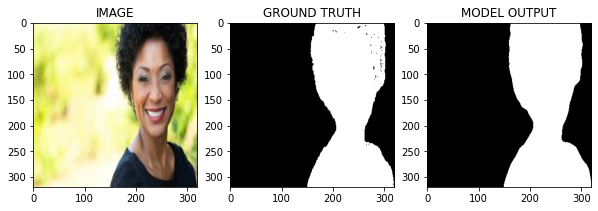

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya